<a href="https://colab.research.google.com/github/arunoda/fastai-v4/blob/master/07_1_colab_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Coloabrative Filtering with fast.ai**

## Setting Up on Colab

You only need to run this on Colab.

In [1]:
!pip install fastai2 > /dev/null 2>&1
!git clone https://github.com/arunoda/fastai-v4 > /dev/null 2>&1
%cd fastai-v4

/content/fastai-v4


In [0]:
from fastai2.collab import *
from fastai2.tabular.all import *

## **Loading the Dataset**

Here we are going to use a Mini dataset from Movie Lens.

In [3]:
data_path = untar_data(URLs.ML_100k)

In [4]:
!ls -all {data_path}

total 15784
drwxr-xr-x 2 root root    4096 Jun  2 19:17 .
drwxr-xr-x 3 root root    4096 Jun  2 19:17 ..
-rw-r--r-- 1 root root     716 Jun  2 19:17 allbut.pl
-rw-r--r-- 1 root root     643 Jun  2 19:17 mku.sh
-rw-r--r-- 1 root root    6750 Jun  2 19:17 README
-rw-r--r-- 1 root root 1586544 Jun  2 19:17 u1.base
-rw-r--r-- 1 root root  392629 Jun  2 19:17 u1.test
-rw-r--r-- 1 root root 1583948 Jun  2 19:17 u2.base
-rw-r--r-- 1 root root  395225 Jun  2 19:17 u2.test
-rw-r--r-- 1 root root 1582546 Jun  2 19:17 u3.base
-rw-r--r-- 1 root root  396627 Jun  2 19:17 u3.test
-rw-r--r-- 1 root root 1581878 Jun  2 19:17 u4.base
-rw-r--r-- 1 root root  397295 Jun  2 19:17 u4.test
-rw-r--r-- 1 root root 1581776 Jun  2 19:17 u5.base
-rw-r--r-- 1 root root  397397 Jun  2 19:17 u5.test
-rw-r--r-- 1 root root 1792501 Jun  2 19:17 ua.base
-rw-r--r-- 1 root root  186672 Jun  2 19:17 ua.test
-rw-r--r-- 1 root root 1792476 Jun  2 19:17 ub.base
-rw-r--r-- 1 root root  186697 Jun  2 19:17 ub.test
-rw-r--r-- 

In [5]:
!head {data_path/"u.data"}

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


This is the file we want. Here are those fields:

```
user, movie, rating, timestamp
```

In [0]:
df_ml = pd.read_csv(data_path/"u.data", delimiter = "\t", header=None, names=["user", "movie", "rating", "timestamp"])


In [7]:
df_ml.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
dls = CollabDataLoaders.from_df(df_ml, bs=5)

In [9]:
dls.classes

{'movie': (#1645) ['#na#',1,2,3,4,5,6,7,8,9...],
 'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...]}

In [0]:
x, y = dls.one_batch()

In [11]:
x

tensor([[823, 408],
        [271, 477],
        [346, 153],
        [368,  56],
        [201,  51]], device='cuda:0')

In [12]:
y

tensor([[5],
        [3],
        [3],
        [4],
        [2]], device='cuda:0')

So. Based on above data, first col is user and second is movies. `y` containes the result.

For example: **user `49` gave `3` points for movie `581`.**



## **Idea of Colab Filtering**

For now, let's give each movies a 2 factors and 2 factors for each user. So, it'll look like this:

In [0]:
user_factors = torch.randn((len(dls.classes['user']), 2), requires_grad=True)
movie_factors = torch.randn((len(dls.classes['movie']), 2), requires_grad=True)

Let's pick the factors for `49` th user and `581` movie.

In [14]:
user_factors[49], movie_factors[581]

(tensor([-1.0081,  0.2734], grad_fn=<SelectBackward>),
 tensor([0.3196, 0.8271], grad_fn=<SelectBackward>))

Let's create single number from these.

In [15]:
(user_factors[49] * movie_factors[581]).sum()

tensor(-0.0961, grad_fn=<SumBackward0>)

But, let's make sure we are within the 0-5 range.

In [0]:
pred_value = sigmoid_range((user_factors[49] * movie_factors[581]).sum(), 0, 5.1)

Now we need to compare that with the actual value.

In [17]:
(y[0][0] - pred_value).abs()

tensor(2.5725, device='cuda:0', grad_fn=<AbsBackward>)

**That's it. Now we need to get a gradient out of this and update factors**

## **Doing this for a Batch**

Let's try to do this for our whole mini-batch


In [18]:
x

tensor([[823, 408],
        [271, 477],
        [346, 153],
        [368,  56],
        [201,  51]], device='cuda:0')

In [19]:
user_factors

tensor([[-1.4711,  1.0803],
        [-1.6285, -1.0052],
        [ 0.7766, -1.0506],
        ...,
        [ 0.7243, -0.0621],
        [-0.0266,  1.1104],
        [-0.2459,  0.2991]], requires_grad=True)

Basically, we need to pick users in `x` from `user_factors`. But if we do that, it's not a operation which can do gradients. That's where one hot encoding comes to play. So, let's do it.

In [20]:
one_hot([1], 10)

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)

In [0]:
one_hot_i = one_hot(536, len(user_factors)).float()

In [22]:
one_hot_i.shape, user_factors.shape

(torch.Size([944]), torch.Size([944, 2]))

In [23]:
one_hot_i @ user_factors

tensor([-0.4284,  1.6139], grad_fn=<SqueezeBackward3>)

**See. That's supported with gradient calculation.**

Now let's do it for the whole batch


In [24]:
one_hot_users = torch.stack([one_hot(i, len(user_factors)) for i in x[:, 0]]).float()
one_hot_users.shape

torch.Size([5, 944])

In [25]:
one_hot_movies = torch.stack([one_hot(i, len(movie_factors)) for i in x[:, 1]]).float()
one_hot_movies.shape

torch.Size([5, 1645])

In [26]:
picked_user_factors = one_hot_users @ user_factors
picked_user_factors

tensor([[-1.5110, -0.7836],
        [ 0.7612, -1.3311],
        [ 0.2136,  0.3729],
        [-1.9797,  0.3190],
        [-0.8349,  0.9501]], grad_fn=<MmBackward>)

In [27]:
picked_movie_factors = one_hot_movies @ movie_factors
picked_movie_factors

tensor([[ 0.6951, -1.0785],
        [ 2.4628, -0.5587],
        [-0.3919,  2.7058],
        [-0.1449, -1.1980],
        [ 1.5650,  0.7406]], grad_fn=<MmBackward>)

In [28]:
score_preds = sigmoid_range((picked_user_factors * picked_movie_factors).sum(dim=1), 0, 5.1)
score_preds

tensor([2.2892, 4.7533, 3.6521, 2.4286, 1.8037], grad_fn=<AddBackward0>)

In [29]:
loss = (score_preds - y.cpu()[:, 0]).abs().sum()
loss

tensor(6.8840, grad_fn=<SumBackward0>)

In [0]:
loss.backward()

In [31]:
movie_factors.grad.sum(), user_factors.grad.sum()

(tensor(5.2973), tensor(2.5185))

**Above grad some has no meaning. I just wanted show that, getting gradient is possible.**


## Create a Model

Let's create a PyTorch model based on these.

* Create factors
* Then user one_hot encoding to select a given movie
* Then implement model.

In [0]:
class OneHotModel(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = torch.randn((n_users, n_factors), requires_grad=True)
    self.movie_factors = torch.randn((n_movies, n_factors), requires_grad=True)

  def forward(self, batch):
    n_users = len(self.user_factors)
    n_movies = len(self.movie_factors)
    
    users = torch.stack([one_hot(i, n_users) for i in batch[:, 0]]).float() @ self.user_factors
    movies = torch.stack([one_hot(i, n_movies) for i in batch[:, 1]]).float() @ self.movie_factors

    return (users * movies).sum(dim=1)

In [0]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [74]:
## Let's try it
model = DotProduct(2000, 2000, 10)
model.forward(x.cpu())

tensor([-4.0593e-05,  4.3416e-04,  8.2802e-05,  9.5100e-05,  6.5755e-05],
       grad_fn=<SumBackward1>)

In [0]:
## Create the learner
model = OneHotModel(len(dls.classes['user']), len(dls.classes['movie']), 10)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [76]:
learn.fit_one_cycle(5, 5e-5)

IndexError: ignored

This is something with fast.ai not compatible with our model.
So, we need to use Embedding

In [0]:
class EmbedModel(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self, batch):
    ## See this is why we call embedding. Here we simply call for the index
    ## But it's a mathematic operation behind d
    users = self.user_factors(batch[:, 0])
    movies = self.movie_factors(batch[:, 1])

    return (users * movies).sum(dim=1)

In [0]:
model = EmbedModel(len(dls.classes['user']), len(dls.classes['movie']), 10)
learn = Learner(dls, model, loss_func=MSELossFlat())

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=3.311311274956097e-06)

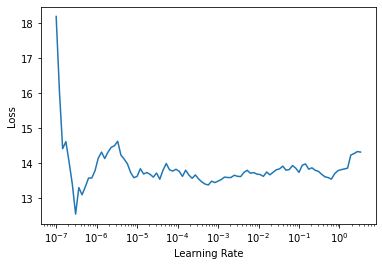

In [87]:
learn.lr_find()

In [89]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,time
0,4.799034,4.494537,01:37
1,2.139998,2.058244,01:37
2,1.805975,1.884207,01:38


**See. It' getting better.**